# Hello, PyTorch:: homework tasks

There are 3 tasks with different relative __point__ worth.
If you get stuck with no progress, try switching to the next task and returning later.

In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall22/week01-pytorch_intro/notmnist.py
    !touch .setup_complete

In [28]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
print(torch.__version__)

1.13.1


In [95]:
%matplotlib inline

### Task I (20% points) - tensormancy

![img](https://media.giphy.com/media/3o751UMCYtSrRAFRFC/giphy.gif)

When dealing with more complex stuff like neural network, it's best if you use tensors the way samurai uses his sword. 


__1.1 The Cannabola__ 
[(_disclaimer_)](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

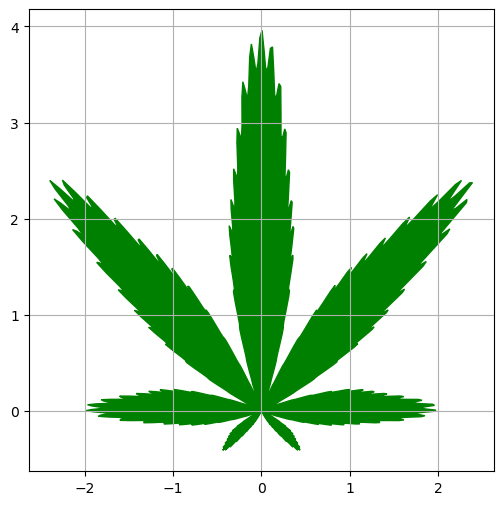

In [4]:
theta = torch.linspace(- np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(8 * theta)) * (1 + 0.1 * torch.cos(24 * theta)) * (0.9 + 0.05 * torch.cos(200 * theta)) * (1 + torch.sin(theta))

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)


plt.figure(figsize=[6, 6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

### Task II: The Game of Life (30% points)

Now it's time for you to make something more challenging. We'll implement Conway's [Game of Life](http://web.stanford.edu/~cdebs/GameOfLife/) in _pure PyTorch_. 

While this is still a toy task, implementing game of life this way has one cool benefit: __you'll be able to run it on GPU!__ Indeed, what could be a better use of your GPU than simulating Game of Life on 1M/1M grids?

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)
If you've skipped the URL above out of sloth, here's the Game of Life:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* Any living cell that has 2 or 3 neighbors survives, else it dies [0,1 or 4+ neighbors]
* Any cell with exactly 3 neighbors becomes alive (if it was dead)

For this task, you are given a reference NumPy implementation that you must convert to PyTorch.
_[NumPy code inspired by: https://github.com/rougier/numpy-100]_


__Note:__ You can find convolution in `torch.nn.functional.conv2d(Z,filters)`. Note that it has a different input format.

__Note 2:__ From the mathematical standpoint, PyTorch convolution is actually cross-correlation. Those two are very similar operations. More info: [video tutorial](https://www.youtube.com/watch?v=C3EEy8adxvc), [scipy functions review](http://programmerz.ru/questions/26903/2d-convolution-in-python-similar-to-matlabs-conv2-question), [stack overflow source](https://stackoverflow.com/questions/31139977/comparing-matlabs-conv2-with-scipys-convolve2d).

In [13]:
from scipy.signal import correlate2d

def np_update(Z):
    # Count neighbours with convolution
    filters = np.array([[1, 1, 1],
                        [1, 0, 1],
                        [1, 1, 1]])

    N = correlate2d(Z, filters, mode='same')
    print(N)

    # Apply rules
    birth = (N == 3) & (Z == 0)
    survive = ((N == 2) | (N == 3)) & (Z == 1)

    Z[:] = birth | survive
    return Z

In [19]:
def torch_update(Z):
    """
    Implement an update function that does to Z exactly the same as np_update.
    :param Z: torch.FloatTensor of shape [height,width] containing 0s(dead) an 1s(alive)
    :returns: torch.FloatTensor Z after updates.

    You can opt to create a new tensor or change Z inplace.
    """
    conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3), stride=1, padding="same", bias=False)
    filters = torch.Tensor([[1, 1, 1],
                    [1, 0, 1],
                    [1, 1, 1]])
    conv.weight.data = filters[None, None, :, :]

    N = conv(Z[None, :, :])[0, :, :]
    # Apply rules
    birth = (N == 3) & (Z == 0)
    survive = ((N == 2) | (N == 3)) & (Z == 1)

    Z[:] = birth | survive

    return Z

In [20]:
# initial frame
Z_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
Z = torch.from_numpy(Z_numpy).type(torch.FloatTensor)

# your debug polygon :)
Z_new = torch_update(Z.clone())

# tests
Z_reference = np_update(Z_numpy.copy())
assert np.all(Z_new.numpy() == Z_reference), \
    "your PyTorch implementation doesn't match np_update. Look into Z and np_update(ZZ) to investigate."
print("Well done!")

[[2 3 1 ... 3 4 2]
 [3 6 4 ... 6 8 4]
 [3 4 3 ... 4 4 2]
 ...
 [1 2 2 ... 5 7 4]
 [0 2 4 ... 5 6 4]
 [0 1 1 ... 3 3 3]]
Well done!


In [21]:
%matplotlib notebook
plt.ion()

# initialize game field
Z = np.random.choice([0, 1], size=(100, 100))
Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    # update
    Z = torch_update(Z)

    # re-draw image
    ax.clear()
    ax.imshow(Z.numpy(), cmap='gray')
    fig.canvas.draw()

<IPython.core.display.Javascript object>

In [23]:
# Some fun setups for your amusement

# parallel stripes
Z = np.arange(100) % 2 + np.zeros([100, 100])
# with a small imperfection
Z[48:52, 50] = 1

Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    Z = torch_update(Z)
    ax.clear()
    ax.imshow(Z.numpy(), cmap='gray')
    fig.canvas.draw()
    fig.show()

<IPython.core.display.Javascript object>

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

### Task III: Going deeper (50% points)
<img src="http://download.gamezone.com/uploads/image/data/1190338/article_post_width_a88.jpg" width=360>
Your ultimate task for this week is to build your first neural network [almost] from scratch and pure PyTorch.

This time you will solve the same digit recognition problem, but at a larger scale

* 10 different letters
* 20k samples

We want you to build a network that reaches at least 80% accuracy and has at least 2 linear layers in it. Naturally, it should be nonlinear to beat logistic regression.

With 10 classes you will need to use __Softmax__ at the top instead of sigmoid and train using __categorical crossentropy__  (see [here](http://wiki.fast.ai/index.php/Log_Loss)). You can write loss any way you want, but we recommend merging log-loss with the last layer softmax, since it can be simplified.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you an edge over logistic regression.

__Win conditions:__
* __Your model must be nonlinear,__ but not necessarily deep.
* __Train your model once with SGD, and again with Momentum, RMSProp or Adam__ - which you will have to implement
* __For this task only, please do not use the contents of `torch.nn` and `torch.optim`.__ That's for the next task.




__[bonus kudos]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! It should be possible to reach 90% without convnets.

__SPOILERS!__
At the end of the notebook you will find a few tips and frequent errors. 
If you feel confident enough, just start coding right away and get there ~~if~~ once you need to untangle yourself.

In [25]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

--2023-01-11 10:48:14--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8458043 (8,1M) [application/x-gzip]
Saving to: ‘notMNIST_small.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  164K 50s
    50K .......... .......... .......... .......... ..........  1%  328K 37s
   100K .......... .......... .......... .......... ..........  1% 42,6M 25s
   150K .......... .......... .......... .......... ..........  2%  330K 25s
   200K .......... .......... .......... .......... ..........  3% 48,7M 20s
   250K .......... .......... .......... .......... ..........  3% 78,7M 16s
   300K .......... .......... .......... .......... ..........  4%  110M 14s
   350K .......... .......... .......... .......... ..........  4%  123M 12s
   400K .......... .......... .....

Extracting ...
Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [54]:
def oh_encode(y):
    output = np.zeros((len(y), 10))
    for idx, i in enumerate(y):
        output[idx, i] = 1
    return output

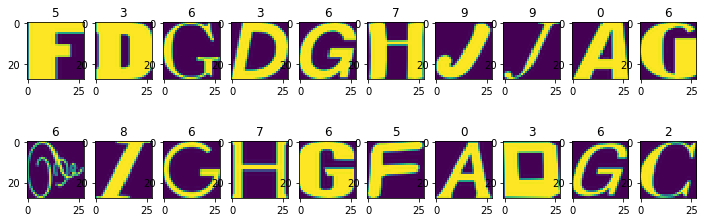

In [ ]:
%matplotlib inline
plt.figure(figsize=[12, 4])
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i].reshape([28, 28]))
    plt.title(str(y_train[i]))

In [26]:
X_train.shape

(14043, 784)

In [43]:
model = nn.Sequential(
    nn.Linear(784, 256),   # add first "dense" layer with 784 input units and 1 output unit.
    nn.ReLU(),
    nn.Linear(256, 10),
    nn.Sigmoid(),         # add softmax activation for probabilities. Normalize over axis 1
    nn.Softmax()                  
)

In [85]:
def cat_crossentropy(pred, y):
    crossentropy = -torch.sum(y * torch.log(pred), axis=-1)
    return crossentropy

def crossentropy_loss(pred, y):
    return torch.mean(cat_crossentropy(pred, y))

In [65]:
oh_encode(y_train[:3])

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [66]:
y_train[:3]

array([1, 2, 3])

In [67]:
X_small, y_small = torch.tensor(X_train[:3, :], dtype=torch.float32), torch.tensor(oh_encode(y_train[:3]), dtype=torch.float32)

pred = model(X_small)
print(pred)

tensor([[0.0947, 0.0979, 0.1024, 0.1023, 0.0912, 0.0945, 0.1027, 0.0981, 0.1131,
         0.1029],
        [0.0956, 0.1028, 0.0956, 0.0927, 0.0968, 0.0972, 0.1007, 0.1090, 0.0985,
         0.1112],
        [0.0999, 0.0923, 0.0952, 0.0838, 0.0993, 0.0969, 0.1122, 0.1001, 0.1143,
         0.1061]], grad_fn=<SoftmaxBackward0>)


In [69]:
crossentropy_loss(pred, y_small)

tensor(-2.3835, grad_fn=<NegBackward0>)

In [120]:
model = nn.Sequential(
    nn.Linear(784, 10),   # add first "dense" layer with 784 input units and 1 output unit.
    nn.Sigmoid(),         # add softmax activation for probabilities. Normalize over axis 1
    nn.Softmax()                  
)

model = nn.Sequential(
    nn.Linear(784, 256),   # add first "dense" layer with 784 input units and 1 output unit.
    nn.ReLU(),
    nn.Linear(256, 10),
    nn.Sigmoid(),         # add softmax activation for probabilities. Normalize over axis 1
    nn.Softmax()                  
)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [121]:
history = []

for i in range(10000):

    # sample 256 random images
    ix = np.random.randint(0, len(X_train), 256)
    x_batch = torch.tensor(X_train[ix], dtype=torch.float32)
    y_batch = torch.tensor(oh_encode(y_train[ix]), dtype=torch.float32)

    # predict probabilities
    y_predicted =  model(x_batch)

    # compute loss, just like before
    loss =  crossentropy_loss(y_predicted, y_batch)

    # compute gradients
    loss.backward()

    # Adam step
    opt.step()

    # clear gradients
    opt.zero_grad()

    history.append(loss.data.numpy())

    if i % 100 == 0:
        print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))

step #0 | mean loss = 2.313
step #100 | mean loss = 1.568
step #200 | mean loss = 1.551
step #300 | mean loss = 1.534
step #400 | mean loss = 1.526
step #500 | mean loss = 1.522
step #600 | mean loss = 1.518
step #700 | mean loss = 1.512
step #800 | mean loss = 1.502
step #900 | mean loss = 1.502
step #1000 | mean loss = 1.500
step #1100 | mean loss = 1.502
step #1200 | mean loss = 1.505
step #1300 | mean loss = 1.502
step #1400 | mean loss = 1.494
step #1500 | mean loss = 1.499
step #1600 | mean loss = 1.491
step #1700 | mean loss = 1.496
step #1800 | mean loss = 1.499
step #1900 | mean loss = 1.492
step #2000 | mean loss = 1.492
step #2100 | mean loss = 1.489
step #2200 | mean loss = 1.493
step #2300 | mean loss = 1.488
step #2400 | mean loss = 1.493
step #2500 | mean loss = 1.492
step #2600 | mean loss = 1.488
step #2700 | mean loss = 1.490
step #2800 | mean loss = 1.491
step #2900 | mean loss = 1.488
step #3000 | mean loss = 1.493
step #3100 | mean loss = 1.489
step #3200 | mean lo

In [122]:
# use your model to predict classes (0 or 1) for all test samples
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
predicted_y_test_prob =  model(X_test_tensor).data.numpy()
predicted_y_test = np.argmax(predicted_y_test_prob, axis=1)
print(predicted_y_test.shape)

assert isinstance(predicted_y_test, np.ndarray), "please return np array, not %s" % type(
    predicted_y_test)
assert predicted_y_test.shape == y_test.shape, "please predict one class for each test sample"
assert np.in1d(predicted_y_test, y_test).all(), "please predict class indexes"

accuracy = np.mean(predicted_y_test == y_test)

print("Test accuracy: %.5f" % accuracy)
assert accuracy > 0.95, "try training longer"

(4681,)
Test accuracy: 0.92245


AssertionError: try training longer

In [123]:
y_test

array([5, 1, 8, ..., 6, 4, 5])

In [124]:
predicted_y_test

array([5, 1, 8, ..., 6, 8, 5])

In [109]:
for i in predicted_y_test_prob[:10, :]:
    print(i)

[0.08436574 0.08436576 0.08437306 0.08436574 0.09573688 0.22932978
 0.08436574 0.08436576 0.08436574 0.08436574]
[0.08594396 0.22649357 0.08594396 0.08594396 0.08595461 0.08594396
 0.08594396 0.08594396 0.08594396 0.08594396]
[0.07813973 0.07815222 0.07813519 0.07813714 0.16259879 0.07813519
 0.07813533 0.07813522 0.2122939  0.07813723]
[0.08534476 0.23192377 0.0853414  0.08534157 0.0853414  0.0853414
 0.08534142 0.08534141 0.0853414  0.08534143]
[0.22854294 0.08407738 0.08407738 0.08407738 0.08407772 0.08414634
 0.08457398 0.08421682 0.08407738 0.09813273]
[0.07994621 0.07992302 0.08008517 0.07992512 0.21720202 0.07992312
 0.07992302 0.08066121 0.14248808 0.07992302]
[0.0853347  0.08533854 0.0853347  0.08533964 0.0853347  0.0853347
 0.08534976 0.0853347  0.0853347  0.23196377]
[0.08533636 0.08533716 0.08533636 0.08533676 0.08533684 0.23196827
 0.0853392  0.08533636 0.08533636 0.08533636]
[0.08531458 0.23190907 0.08531458 0.08531571 0.08531458 0.085343
 0.08554476 0.08531459 0.08531458

<br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/>

# SPOILERS!

Recommended pipeline:

* Adapt logistic regression from previous assignment to classify one letter against others (e.g. A vs the rest)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - Softmax (exp over sum of exps) can be implemented manually or as `torch.softmax` (function)
  - Probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
    - You can also try momentum/rmsprop/adawhatever
    - in which case the dataset should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (e.g. sigmoid) instead of softmax
  - You need to train both layers, not just the output layer :)
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve. 
  - In ideal case this totals to 2 `torch.matmul`'s, 1 softmax and 1 ReLU/sigmoid
  - __Make sure this neural network works better than logistic regression!__
  
* Now's the time to try improving the network. Consider layers (size, neuron count), nonlinearities, optimization methods, initialization — whatever you want, but please avoid convolutions for now.
  
* If anything seems wrong, try going through one step of training and printing everything you compute.
* If you see NaNs midway through optimization, you can estimate $\log P(y \mid x)$ as `torch.log_softmax(last_linear_layer_outputs)`.